In [1]:
# @formatter:off
import random

import numpy as np
import sklearn.ensemble
%load_ext autoreload
%autoreload 2
# @formatter:on
import os

os.chdir('../')
print(os.getcwd())

/home/viktor/workspace/smaite


In [2]:
#@formatter:off
files = !ls data/*csv.jsonl
#@formatter:on
files = [f for f in files if 'sample' not in f and 'augmented' not in f and 'processed' not in f]
assert len(files) == 8

In [3]:
import json
from tqdm.notebook import tqdm
from unidecode import unidecode


def load_json(d):
    try:
        return json.loads(d, strict=False)
    except Exception as e:
        print("FEK")
        print(d)
        print(unidecode(d))
        return json.loads(unidecode(d), strict=False)


def load_jsonl(path: str):
    print("loading", path)
    with open(path) as f:
        return [load_json(d) for d in tqdm(f.readlines())]


datasets = [load_jsonl(p) for p in files]

loading data/bbc.csv.jsonl


  0%|          | 0/246 [00:00<?, ?it/s]

loading data/climatefeedback.csv.jsonl


  0%|          | 0/136 [00:00<?, ?it/s]

loading data/factcheck.csv.jsonl


  0%|          | 0/6000 [00:00<?, ?it/s]

loading data/fullfact.csv.jsonl


  0%|          | 0/4060 [00:00<?, ?it/s]

loading data/nytimes.csv.jsonl


  0%|          | 0/508 [00:00<?, ?it/s]

loading data/politifact.csv.jsonl


  0%|          | 0/5400 [00:00<?, ?it/s]

loading data/snopes.csv.jsonl


  0%|          | 0/4499 [00:00<?, ?it/s]

loading data/washingtonpost.csv.jsonl


  0%|          | 0/1416 [00:00<?, ?it/s]

In [20]:
claims = [d['text'] for ds in datasets for d in ds]
print(len(claims))

22265


In [11]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [12]:
def do_lda(texts, max_df, min_df, n_features, n_topics, max_iter, idf=False):
    if idf:
        tf_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df,
                                        max_features=n_features,
                                        stop_words='english')

    else:
        tf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df,
                                        max_features=n_features,
                                        stop_words='english')

    tf_matrix = tf_vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=max_iter,
                                    learning_method='online',
                                    learning_offset=30.,
                                    random_state=0)
    lda.fit(tf_matrix)
    tf_feature_names = tf_vectorizer.get_feature_names()
    return lda, tf_feature_names

/home/viktor/.conda/envs/tanc/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


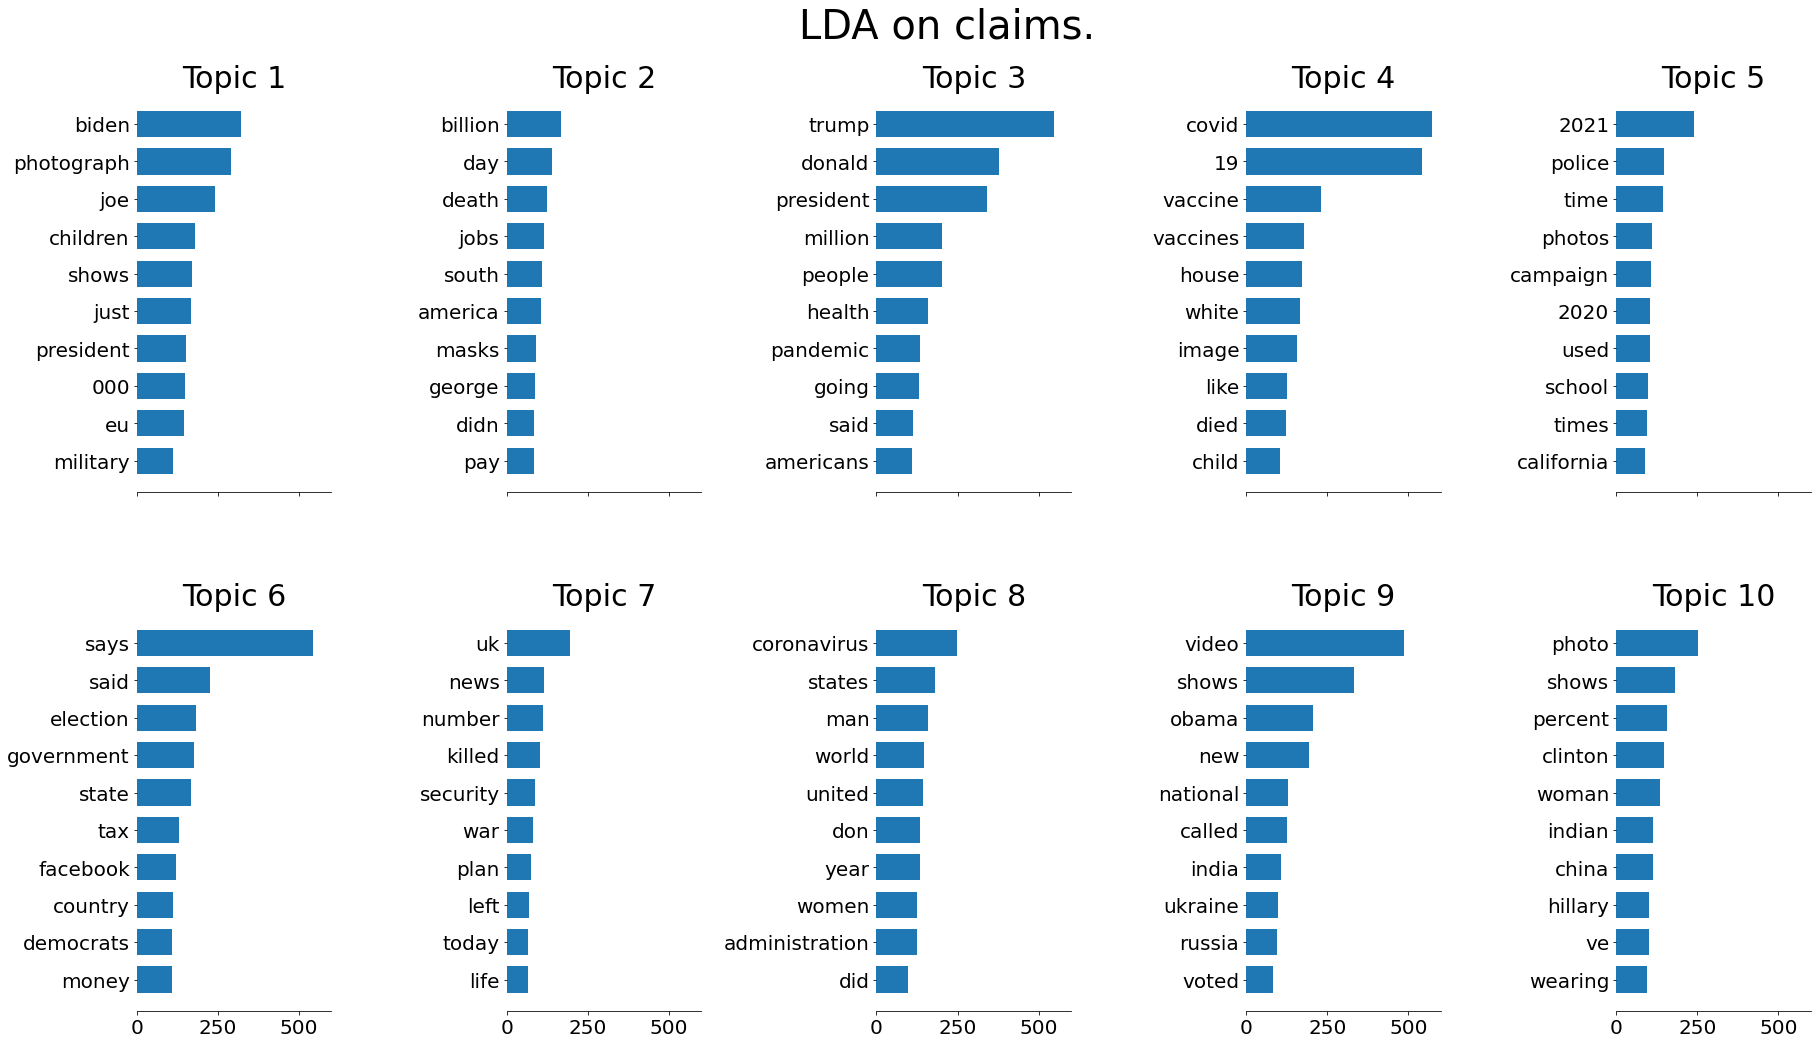

In [19]:
n_features = 500  # Max words to consider
max_df = 0.50  # Consider words that only appear in at most 60% of the docs.
min_df = 10  # Consider words that appear at least 5 times across all documents.
n_topics = 10  # number of topics
n_top_words = 10  # number of words to display per topic
max_iter = 10  # How long to train for

lda, words = do_lda(claims, max_df, min_df, n_features, n_topics, max_iter, idf=False)
plot_top_words(lda, words, n_top_words, 'LDA on claims.')